In [1]:
!pip install tensorflow_addons mediapipe --quiet

In [9]:
import os
import cv2
import csv
import math
import json
import scipy
import sklearn
import numpy as np
import pandas as pd
# import mediapipe as mp
import tensorflow as tf
import plotly.express as px
from tqdm.notebook import tqdm
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import deque
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers
import matplotlib.animation as animation
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GroupShuffleSplit

In [4]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = False
TRAIN_MODEL = True
# True: use 10% of participants as validation set
# False: use all data for training -> gives better LB result
USE_VAL = False
N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250
INPUT_SIZE = 64
BATCH_ALL_SIGNS_N = 3
BATCH_SIZE = 512
LR_MAX = 1e-3
# LR_MAX = 0.005 # #3
# LR_MAX = 0.00155 # #3
N_WARMUP_EPOCHS = 50
WD_RATIO = 0.05
MASK_VAL = 4237
N_EPOCHS = 150
VERBOSE = 1

In [17]:
NUM_CLASSES = 250
NUM_BLOCKS= 2
N_ROWS = 543
N_DIMS = 3

# final embedding and transformer embedding size
UNITS = 512 # WAS 512

# Transformer
MLP_RATIO = 4

# Dropout
EMBEDDING_DROPOUT= 0.00
MLP_DROPOUT_RATIO = 0.30 # WAS 0.40
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu
BATCH_ALL_SIGNS_N = 3

In [18]:
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512
WD_RATIO = 0.05
INPUT_SIZE = 64
N_DIMS = 3

In [19]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
LHAND = np.arange(468, 489) # 21
RHAND = np.arange(522, 543) # 21
# POSE  = np.arange(489, 522)# 33
FACE  = np.arange(0,468) #468
LIP = np.array([ 0,
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
])
LPOSE = np.array([502, 504, 506, 508, 510])
RPOSE = np.array([503, 505, 507, 509, 511])

# Concatenate the relevant landmarks for each dominant hand scenario
left_hand_dominant = np.concatenate((LIP, LHAND, LPOSE))
right_hand_dominant = np.concatenate((LIP, RHAND, RPOSE))
# landmarks = np.concatenate((LIP, RHAND, LHAND, POSE))
hand_index = np.concatenate((LHAND, RHAND), axis = 0)

#Landmark Indices in preprocess data
hands_index = np.argwhere(np.isin(left_hand_dominant, hand_index)).squeeze()
lip_index = np.argwhere(np.isin(left_hand_dominant, LIP)).squeeze()
left_hand_index = np.argwhere(np.isin(left_hand_dominant, LHAND)).squeeze()
right_hand_index = np.argwhere(np.isin(left_hand_dominant, RHAND)).squeeze()
pose_index = np.argwhere(np.isin(left_hand_dominant, LPOSE)).squeeze()
n_cols = left_hand_dominant.size

In [20]:
LIPS_START = 0
LEFT_HAND_START = lip_index.size
RIGHT_HAND_START = LEFT_HAND_START + left_hand_index.size
POSE_START = RIGHT_HAND_START + right_hand_index.size
print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


In [21]:
with open('/kaggle/input/asl-signs/sign_to_prediction_index_map.json') as f:
    sign_map = json.load(f)

signs = list(sign_map)


In [22]:
signs[:5]

['TV', 'after', 'airplane', 'all', 'alligator']

In [23]:
BASE_DIR = '/kaggle/input/asl-signs/'
train = pd.read_csv(f'{BASE_DIR}/train.csv')

In [24]:
def mapping_sign_code(sign: str):
    return sign_map[sign]
train['sign_code'] = train['sign'].apply(mapping_sign_code)

In [25]:
BASE_DIR_2 = '/kaggle/input/part-dataset'

# Load Train
X_train = np.load(f'{BASE_DIR_2}/X_train.npy')
y_train = np.load(f'{BASE_DIR_2}/y_train.npy')
NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{BASE_DIR_2}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
# Load Test
X_test = np.load(f'{BASE_DIR_2}/X_test.npy')
y_test = np.load(f'{BASE_DIR_2}/y_test.npy')
NON_EMPTY_FRAME_IDXS_TEST = np.load(f'{BASE_DIR_2}/NON_EMPTY_FRAME_IDXS_TEST.npy')
# Load Val
X_val = np.load(f'{BASE_DIR_2}/X_val.npy')
y_val = np.load(f'{BASE_DIR_2}/y_val.npy')
NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{BASE_DIR_2}/NON_EMPTY_FRAME_IDXS_VAL.npy')
# Define validation Data
validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)

In [26]:
lip_data = X_train[:, :, :40]
left_hand_data = X_train[:, :, 40:61]
pose_data = X_train[:, :, 61:66]

In [27]:
# Instantiate the encoder
le = LabelEncoder()

# Fit the encoder and transform the 'sign' column
train['sign_code'] = le.fit_transform(train['sign'])

# Create dictionaries for mapping
SIGN2ORD = dict(zip(le.classes_, le.transform(le.classes_)))
ORD2SIGN = dict(zip(le.transform(le.classes_), le.classes_))

In [28]:
LEFT_HANDS_MEAN_X = np.zeros([21], dtype=np.float32)
LEFT_HANDS_MEAN_Y = np.zeros([21], dtype=np.float32)
LEFT_HANDS_STD_X = np.zeros([21], dtype=np.float32)
LEFT_HANDS_STD_Y = np.zeros([21], dtype=np.float32)

for landmark_idx in range(21):
    for coord_idx in range(2):  # we consider only X and Y
        # we remove zero points
        coordinate_data = left_hand_data[:, :, landmark_idx, coord_idx]
        valid_points = coordinate_data[coordinate_data != 0]
        if coord_idx == 0:  # X
            LEFT_HANDS_MEAN_X[landmark_idx] = valid_points.mean()
            LEFT_HANDS_STD_X[landmark_idx] = valid_points.std()
        else:  # Y
            LEFT_HANDS_MEAN_Y[landmark_idx] = valid_points.mean()
            LEFT_HANDS_STD_Y[landmark_idx] = valid_points.std()

LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T



In [29]:
POSE_MEAN_X = np.zeros([5], dtype=np.float32)
POSE_MEAN_Y = np.zeros([5], dtype=np.float32)
POSE_STD_X = np.zeros([5], dtype=np.float32)
POSE_STD_Y = np.zeros([5], dtype=np.float32)

for landmark_idx in range(5):
    for coord_idx in range(2):  # we consider only X and Y
        # we remove zero points
        coordinate_data = pose_data[:, :, landmark_idx, coord_idx]
        valid_points = coordinate_data[coordinate_data != 0]
        if coord_idx == 0:  # X
            POSE_MEAN_X[landmark_idx] = valid_points.mean()
            POSE_STD_X[landmark_idx] = valid_points.std()
        else:  # Y
            POSE_MEAN_Y[landmark_idx] = valid_points.mean()
            POSE_STD_Y[landmark_idx] = valid_points.std()

POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T


In [30]:
LIP_MEAN_X = np.zeros([40], dtype=np.float32)
LIP_MEAN_Y = np.zeros([40], dtype=np.float32)
LIP_STD_X = np.zeros([40], dtype=np.float32)
LIP_STD_Y = np.zeros([40], dtype=np.float32)

for landmark_idx in range(40):
    for coord_idx in range(2):  # we consider only X and Y
        # we remove zero points
        coordinate_data = lip_data[:, :, landmark_idx, coord_idx]
        valid_points = coordinate_data[coordinate_data != 0]
        if coord_idx == 0:  # X
            LIP_MEAN_X[landmark_idx] = valid_points.mean()
            LIP_STD_X[landmark_idx] = valid_points.std()
        else:  # Y
            LIP_MEAN_Y[landmark_idx] = valid_points.mean()
            LIP_STD_Y[landmark_idx] = valid_points.std()

LIP_MEAN = np.array([LIP_MEAN_X, LIP_MEAN_Y]).T
LIP_STD = np.array([LIP_STD_X, LIP_STD_Y]).T

In [31]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, n_cols, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)

    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)

    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [32]:
# The `LandmarkEmbedding` class is responsible for generating embeddings for a specific type of landmark.
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units

    def build(self, input_shape):
        # The 'empty_embedding' represents the case when a landmark is missing from a given frame. EMBEDDING FOR WHEN LANDMARK IS MISSING FROM A FRAME
        # It is initialized as a zero vector of size equal to `units`.
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        '''
        A Dense Neural Network Layer is being used to map the input data to a point (or a vector) in the embedding space.
        Therefore similar or related input data are being mapped to points that are close together in the embedding space,
        while unrelated or dissimilar data will be mapped to points that are further apart.

        The coordinates of the landmarks are transformed from their original space (where they might just represent spatial
        coordinates) to an "embedding space" where the coordinates carry more semantic meaning that can help the model understand
        the gestures or signs being made.
        '''
        # Transforming the landmark data(Lips, Hands, Pose) into the embedding space by passing the data through two fully connected 'dense' layers with GELU activations.
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer='glorot_uniform'),
            tf.keras.layers.Activation('gelu'),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer='he_uniform'),
        ], name=f'{self.name}_dense')

    def call(self, x):
        # If a landmark is missing from a frame (indicated by a zero sum of the landmark coordinates),
        # the 'empty_embedding' is returned. Otherwise, the dense layers are applied to generate the embedding.
        embedding_output = tf.where(
            tf.reduce_sum(x, axis=2, keepdims=True) == 0,
            self.empty_embedding,
            self.dense(x),
        )
        # Assertion
        tf.debugging.assert_shapes([
            (embedding_output, (None, 64, self.units))
        ])

        return embedding_output


In [33]:
# Generates the final embeddings for all landmarks and combines them.
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        # self.input_size = input_size
        # self.units = units
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # 'positional_embedding' initialized with zero
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)

        # Create the landmark-specific embedding layers
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')

        # The weights for combining the landmark embeddings. Initialized to zeros, they will be learned during training.
        self.landmark_weights = tf.Variable(tf.zeros([3], dtype=tf.float32), name='landmark_weights')

        # A couple of dense layers to further process the combined embeddings
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer='glorot_uniform'),
            tf.keras.layers.Activation('gelu'),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer='he_uniform'),
        ], name='fc')

    def call(self, lips0, left_hand0, pose0, non_empty_frame_idxs, training=False):
        # Embed the landmarks using the respective embedding layers
        lips_embedding = self.lips_embedding(lips0)
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        pose_embedding = self.pose_embedding(pose0)


        # The embeddings are stacked together along a new dimension, and then weighted and summed to form a single vector.
        # The weights are normalized using a softmax function, which ensures that they sum to 1.
        x = tf.stack((lips_embedding, left_hand_embedding, pose_embedding), axis=3)
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)


        # Pass the combined embedding through the two fully connected layers
        x = self.fc(x)
        # print(f'X Shape : {x.shape}')

        # Add the positional embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        # print('Max Frame Index')
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)

        return x
# scaled dot-product and Multiheadattention Transformer
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)

    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()

    def call(self,x, attention_mask):

        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))

        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks

    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))

    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x = x + mlp(x)

        return x
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)
#Dimeji get_model
def get_transformer_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, n_cols, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')

    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    # Random Frame Masking
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )

    x = tf.slice(frames, [0,0,0,0], [-1,INPUT_SIZE, n_cols, 2])

    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIP_MEAN) / LIP_STD,
        )

    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )

    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 5, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )

    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])
    # Embedding
    x = Embedding()(lips, left_hand, pose, non_empty_frame_idxs)

    # Encoder Transformer Block
    x = Transformer(NUM_BLOCKS)(x, mask)

    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)

    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)

    outputs = x

    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)

    # Sparse Categorical Cross Entropy With Label Smoothing
    loss = scce_with_ls
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
# tf.keras.backend.clear_session()
transformer_model = get_transformer_model()

In [10]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio

    def on_epoch_begin(self, epoch, logs=None):
        transformer_model.optimizer.weight_decay = transformer_model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {transformer_model.optimizer.learning_rate.numpy():.2e}, weight decay: {transformer_model.optimizer.weight_decay.numpy():.2e}')
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.5,num_training_steps=N_EPOCHS):
    if current_step < num_warmup_steps:
        return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

In [12]:
class SignificantIncreaseStopping(tf.keras.callbacks.Callback):
    def __init__(self, threshold=20.0, start_epoch=30, monitor_loss='val_loss', monitor_acc='val_acc', acc_check_epochs=3):
        super(SignificantIncreaseStopping, self).__init__()
        self.threshold = threshold
        self.start_epoch = start_epoch
        self.monitor_loss = monitor_loss
        self.monitor_acc = monitor_acc
        self.acc_check_epochs = acc_check_epochs
        self.last_accuracies = deque(maxlen=acc_check_epochs)
        self.best_weights = None
        self.best_acc = -np.inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Save the best weights if current accuracy is greater than the previous best
        current_acc = logs.get(self.monitor_acc)
        if current_acc is not None and current_acc > self.best_acc:
            self.best_acc = current_acc
            self.best_weights = self.model.get_weights()

        # Check for significant increase in loss after start_epoch
        if epoch >= self.start_epoch:
            current_loss = logs.get(self.monitor_loss)
            if current_loss - self.prev_loss > self.threshold:
                print(f"\nCumulative significant increase in `{self.monitor_loss}` detected. Stopping training.")
                if self.best_weights:
                    self.model.set_weights(self.best_weights)
                self.model.stop_training = True

        self.prev_loss = logs.get(self.monitor_loss)

        # Check for constant accuracy
        self.last_accuracies.append(logs.get(self.monitor_acc))
        if len(self.last_accuracies) == self.acc_check_epochs:
          if len(set(self.last_accuracies)) == 1 and current_acc > 0.9: # Check if all accuracies are the same and the current accuracy is > 0.9
            print(f"\nAccuracy has been constant for the last {self.acc_check_epochs} epochs and is greater than 0.9. Stopping training.")
            if self.best_weights:
                self.model.set_weights(self.best_weights)
            self.model.stop_training = True

        # if len(self.last_accuracies) == self.acc_check_epochs and len(set(self.last_accuracies)) == 1 and current_acc > 0.9:

    def on_train_begin(self, logs=None):
        self.prev_loss = np.inf

increase_stopping = SignificantIncreaseStopping(threshold=20.0, start_epoch=30, monitor_loss='val_loss', monitor_acc='val_acc', acc_check_epochs=3)



In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping

# Clear all models in GPU
tf.keras.backend.clear_session()

# Get new fresh model
model = transformer_model


# model.summary()

# Actual Training
transformer_history = model.fit(
        x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
        steps_per_epoch=len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
        epochs=N_EPOCHS,
        # Only used for validation data since training data is a generator
        batch_size=BATCH_SIZE,
        validation_data=validation_data,
        callbacks=[
#             lr_callback,
#             WeightDecayCallback(),
            increase_stopping,
        ],
        verbose = VERBOSE,
)

In [112]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = transformer_history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(transformer_history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = transformer_history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()



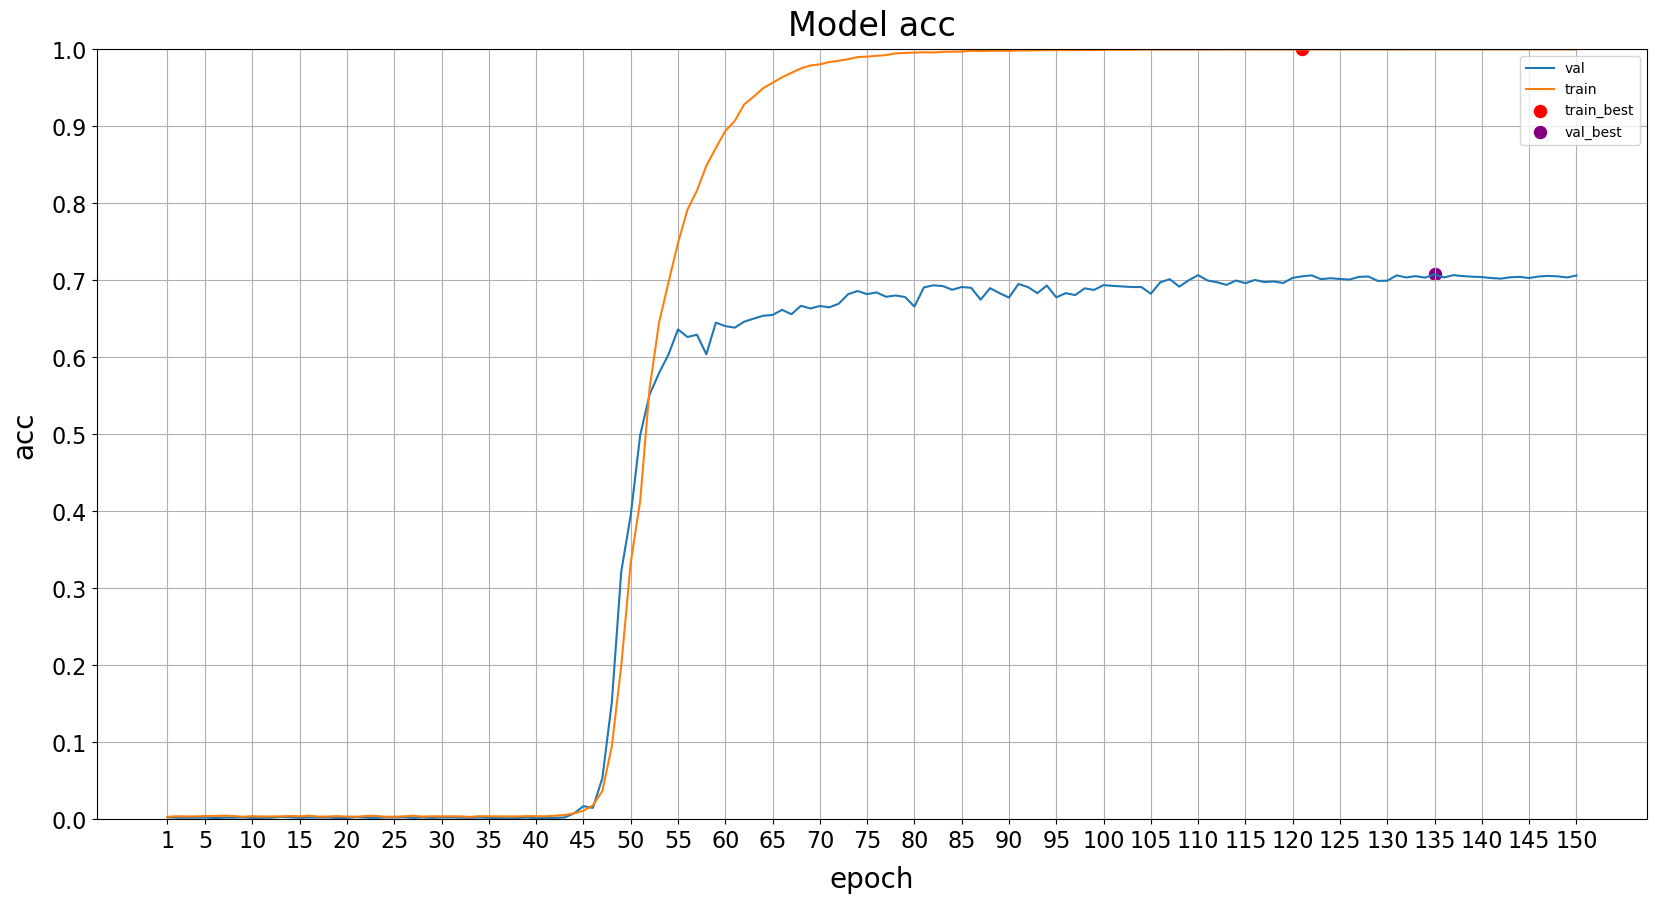

In [26]:
if TRAIN_MODEL:
    plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

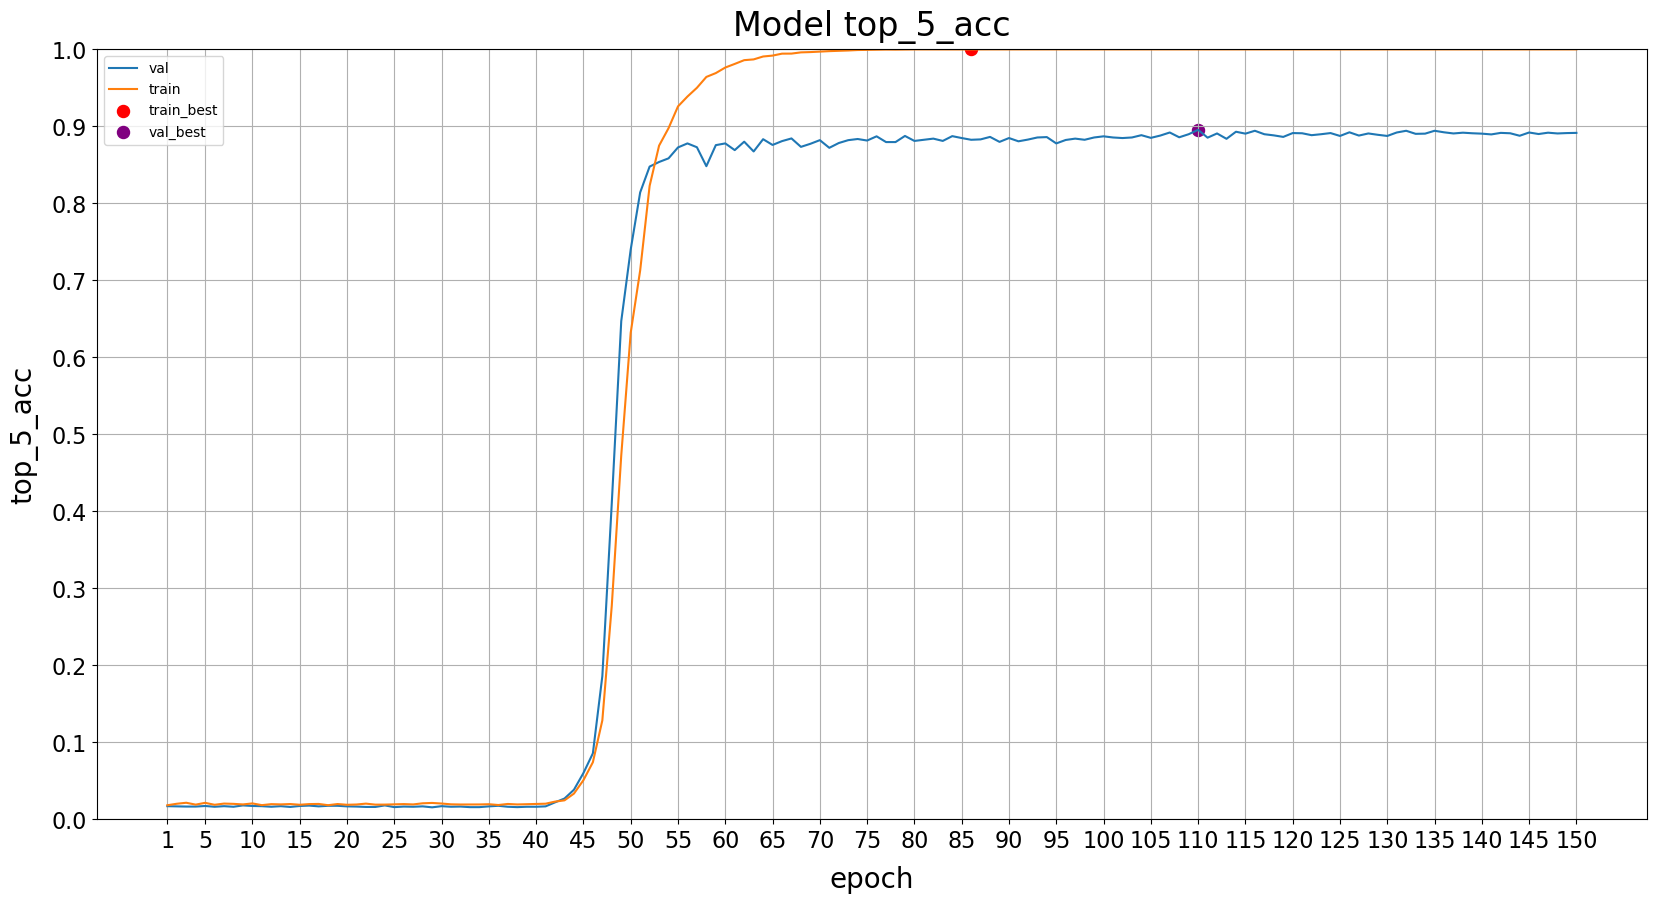

In [27]:
if TRAIN_MODEL:
    plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

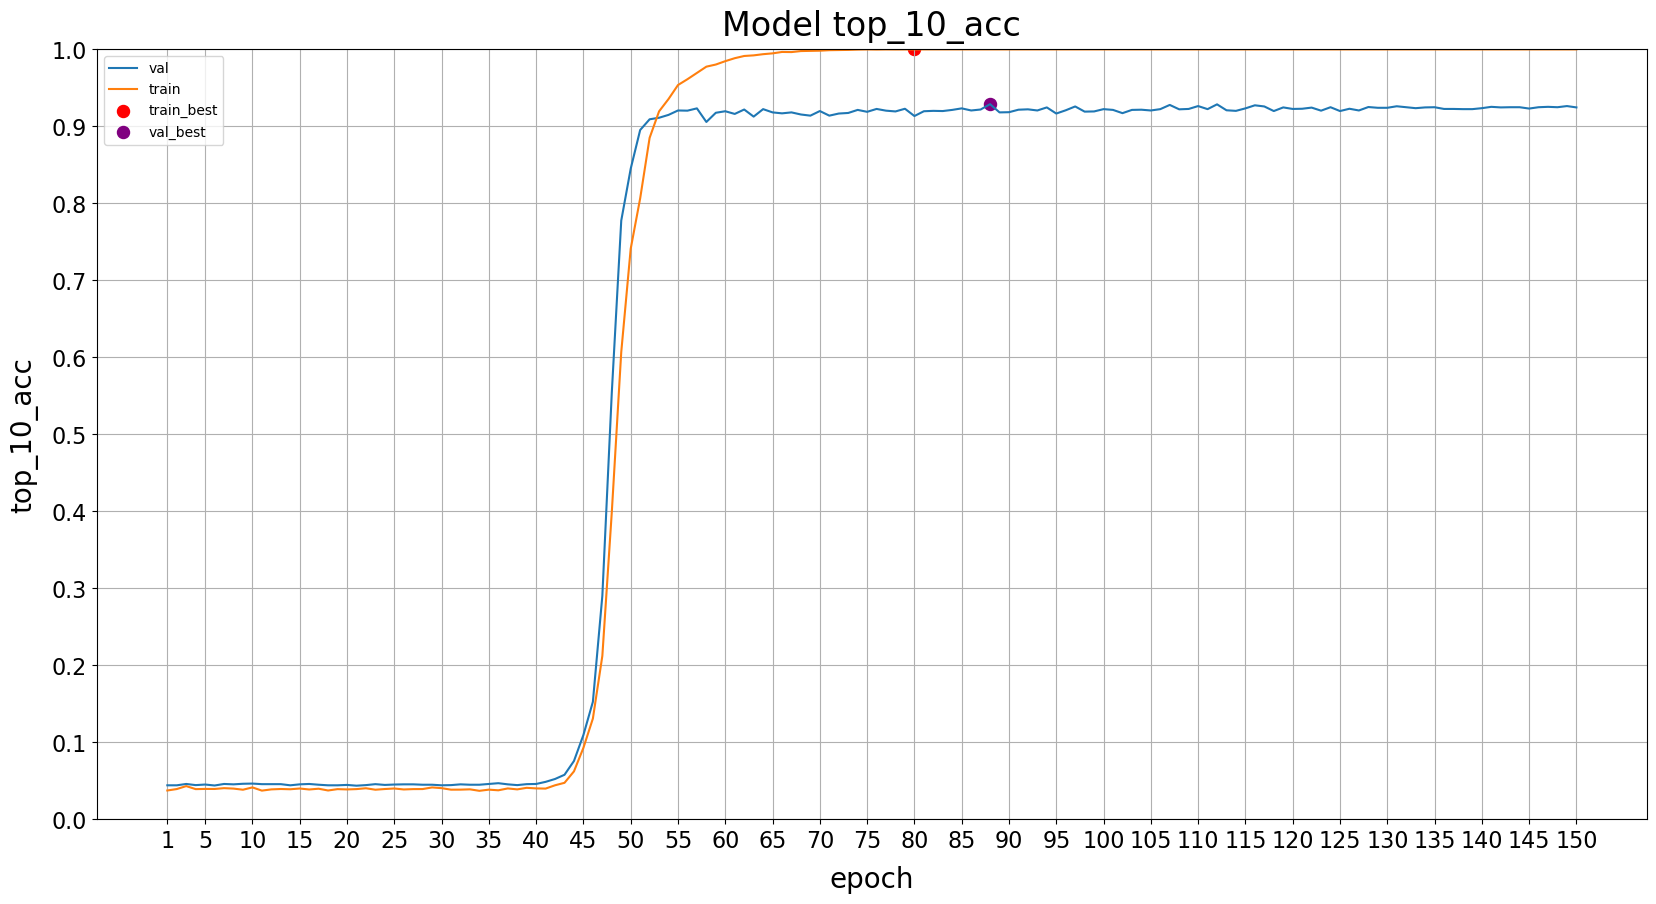

In [28]:
if TRAIN_MODEL:
    plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

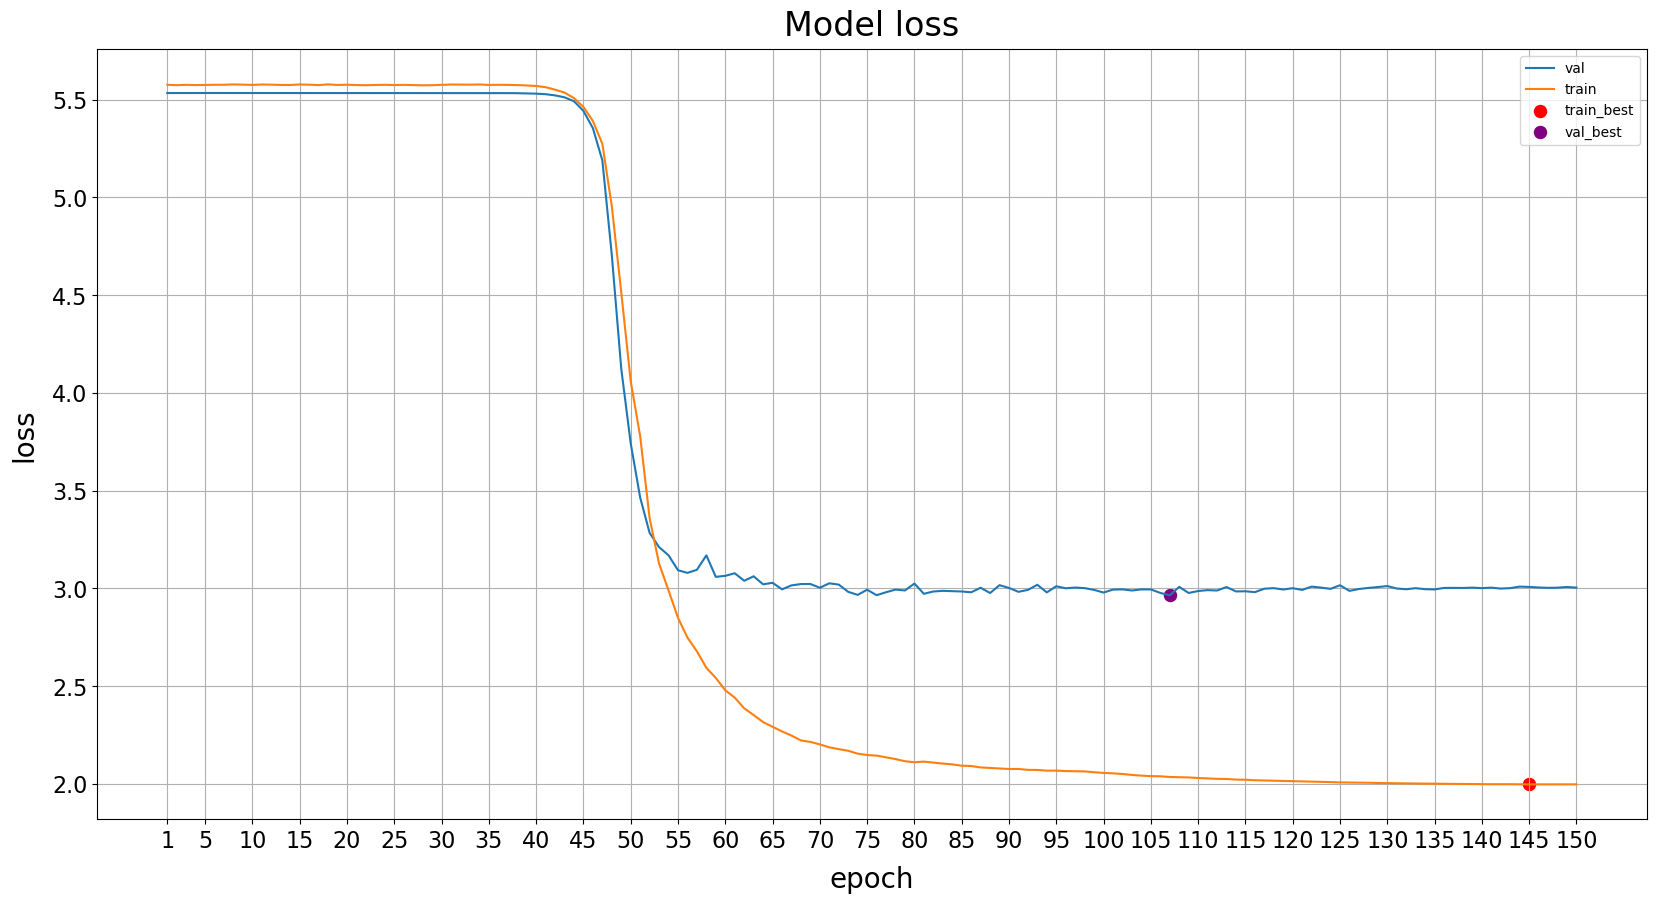

In [29]:
if TRAIN_MODEL:
    plot_history_metric('loss', f_best=np.argmin)

In [123]:
# Validation Predictions
y_val_pred = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
# Label
labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]

126/126 - 3s - 3s/epoch - 21ms/step


In [125]:
#2 BLOCKS
y_pred_probs = model.predict({'frames' : X_test,'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TEST }, verbose=2).argmax(axis=1)
accuracy = accuracy_score(y_test, y_pred_probs)
print(f"Test Accuracy: {accuracy:.4f}")

170/170 - 3s - 3s/epoch - 20ms/step
Test Accuracy: 0.4824


In [43]:
custom_objects = {
    'scce_with_ls': scce_with_ls
}

loaded_model = tf.keras.models.load_model("transformer_model_1", custom_objects=custom_objects)

In [97]:
# Clear all models in GPU
tf.keras.backend.clear_session()

# Get new fresh model
model = transformer_model


# Define the EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


# Sanity Check
model.summary()

# Actual Training
no_lr_transformer_history = model.fit(
        x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
        steps_per_epoch=len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
        epochs=N_EPOCHS,
        # Only used for validation data since training data is a generator
        batch_size=BATCH_SIZE,
        validation_data=validation_data,
        callbacks=[
            lr_callback,
            WeightDecayCallback(),
            increase_stopping,
        ],
        verbose = VERBOSE,
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               
 er)                                                                                              
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']            

In [ ]:
# Validation Predictions
y_val_pred_2 = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
# Label
labels_2 = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]

In [ ]:
y_pred_probs = model.predict({'frames' : X_test,'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TEST }, verbose=2).argmax(axis=1)
accuracy = accuracy_score(y_test, y_pred_probs)
print(f"Test Accuracy: {accuracy:.4f}")

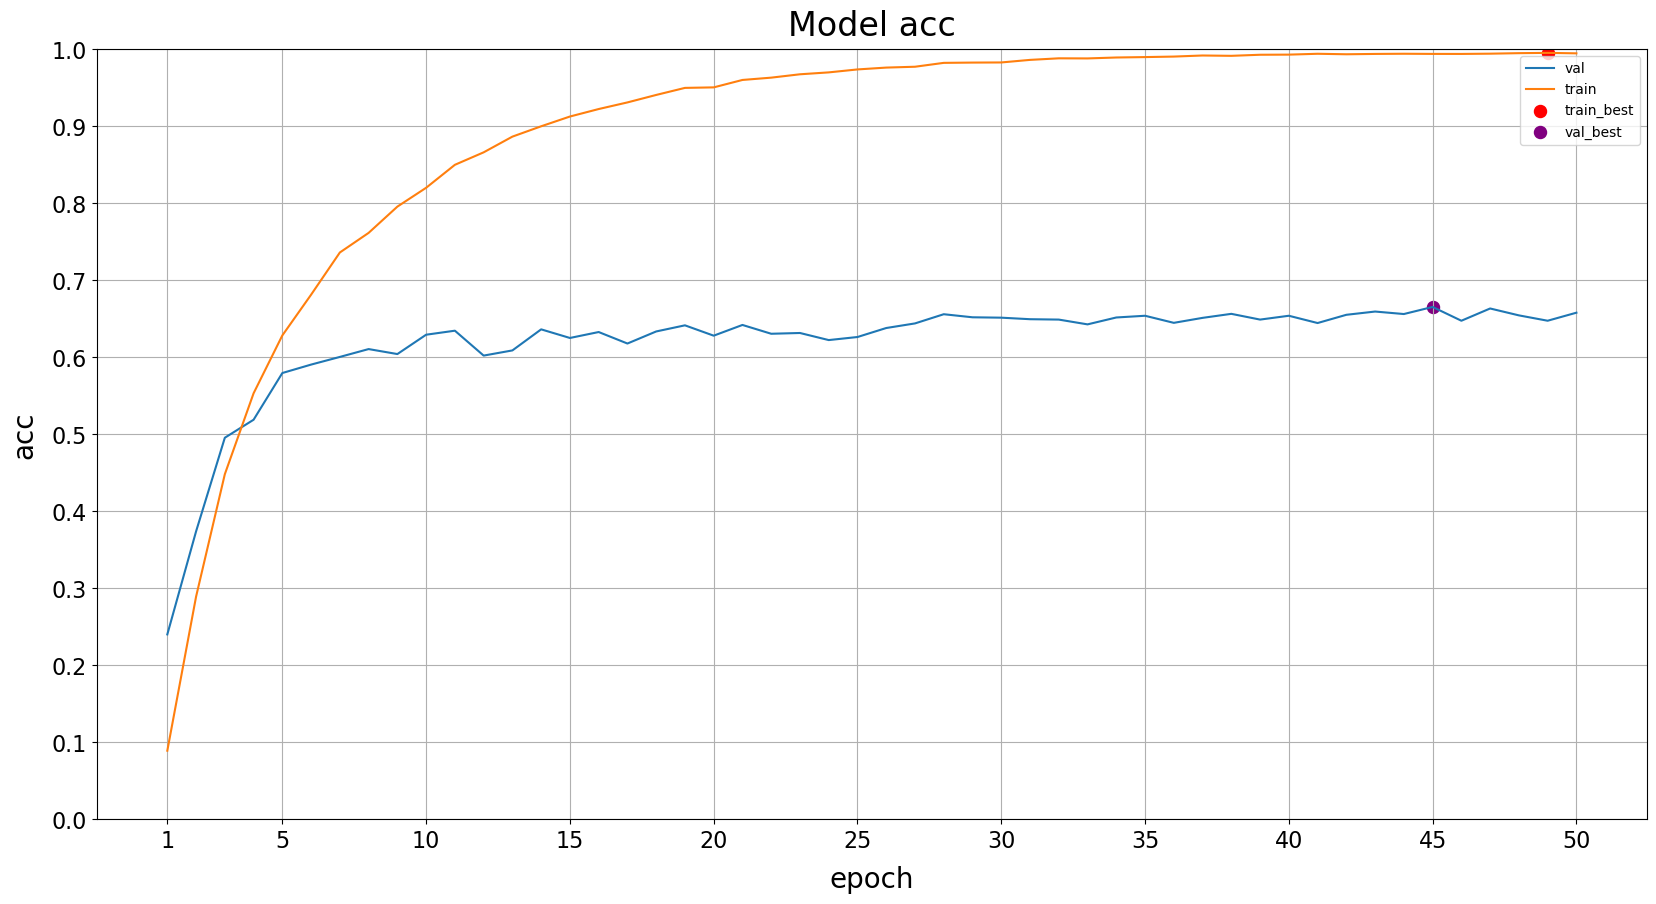

In [113]:
if TRAIN_MODEL:
    plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

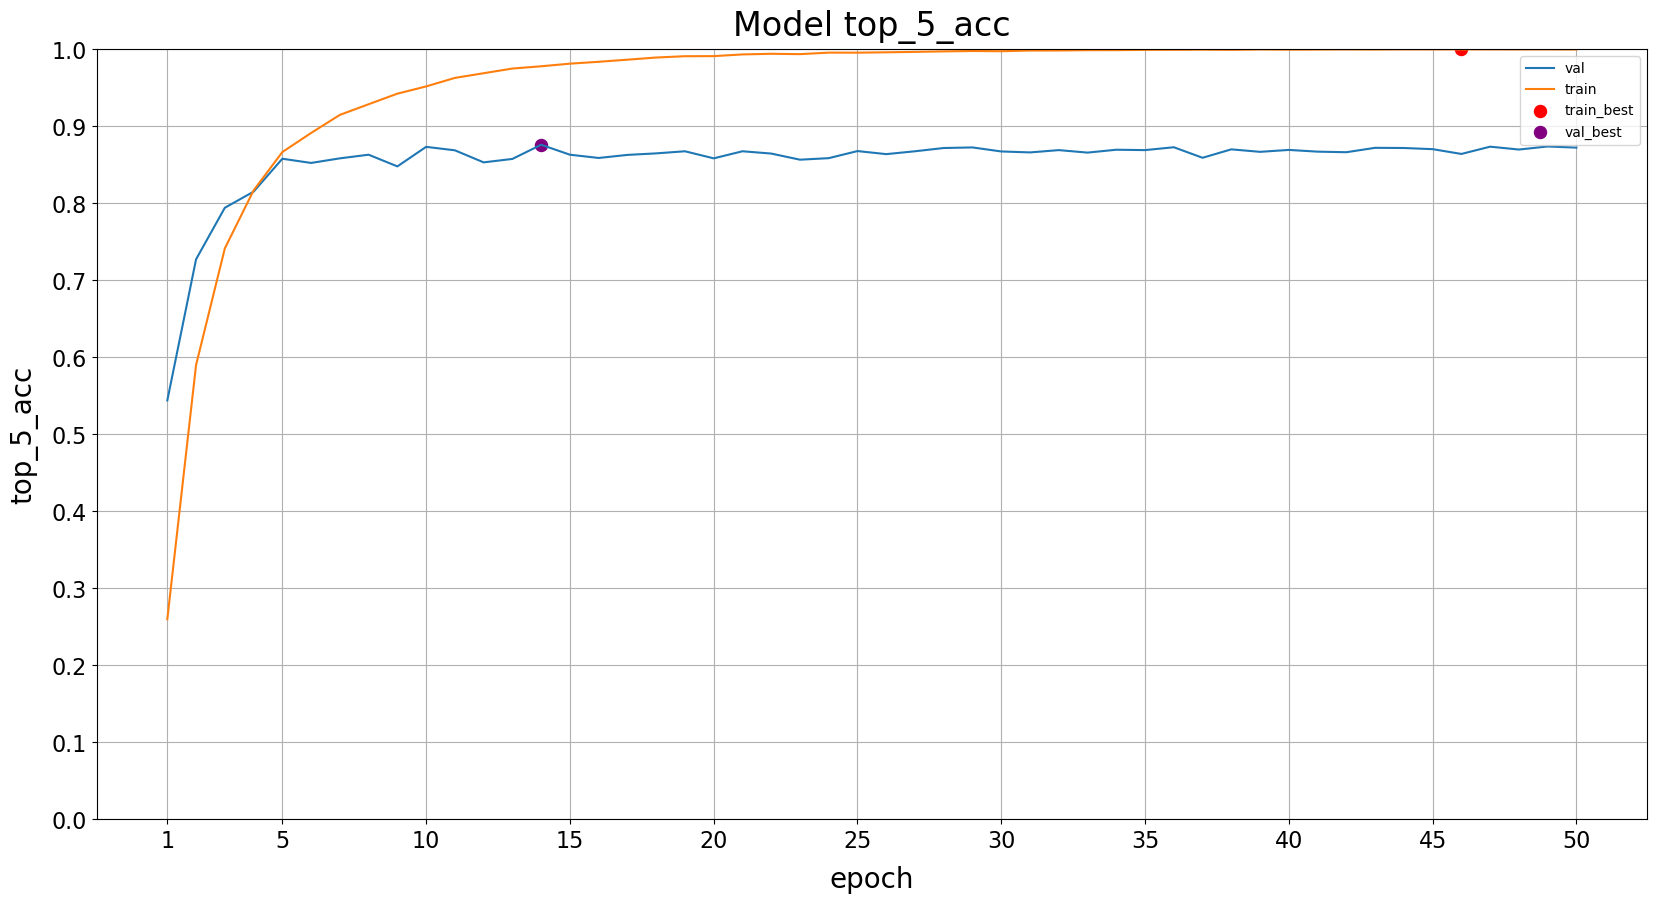

In [114]:
if TRAIN_MODEL:
    plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

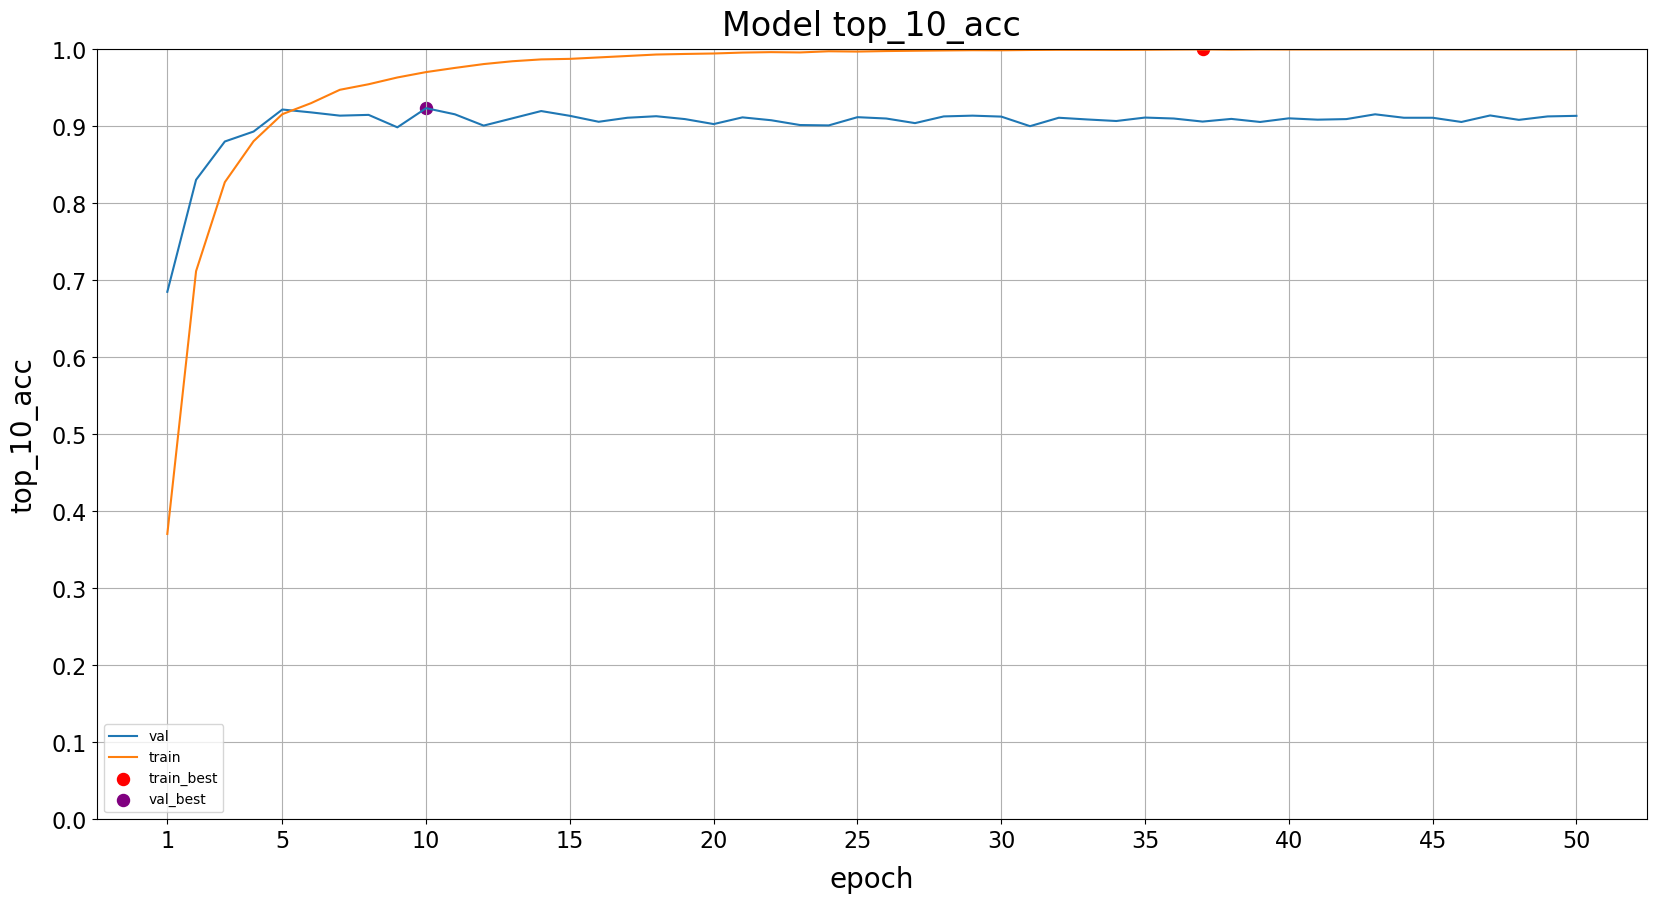

In [115]:
if TRAIN_MODEL:
    plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

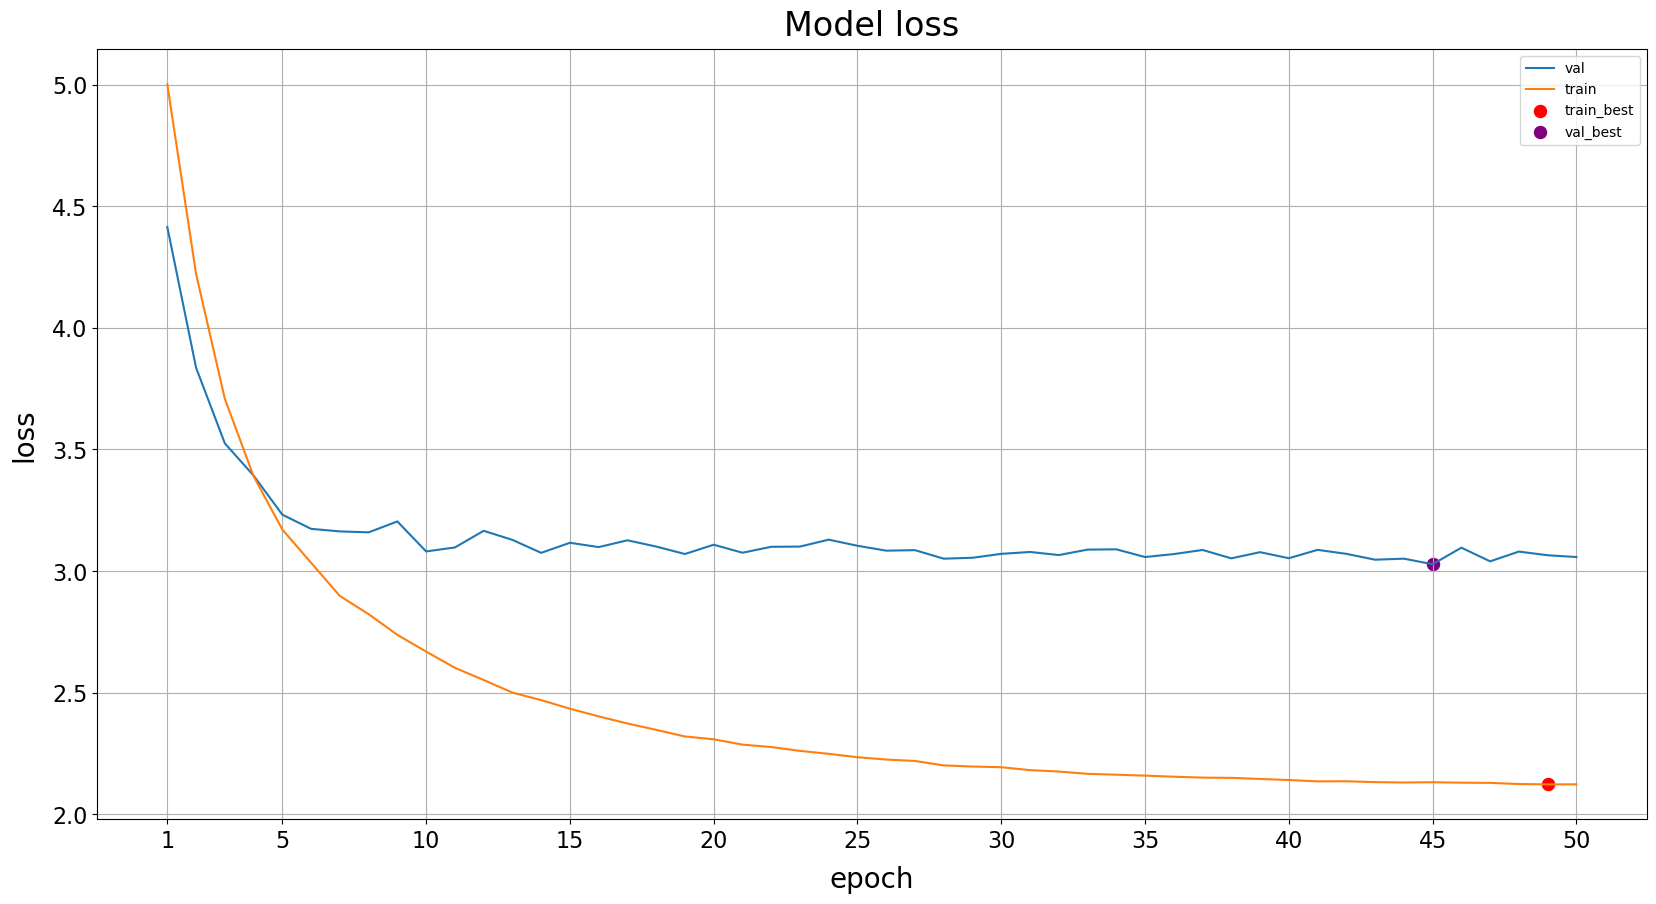

In [116]:
if TRAIN_MODEL:
    plot_history_metric('loss', f_best=np.argmin)

In [13]:
class DenseBlock(layers.Layer):
    def __init__(self, units, drop):
        super().__init__()
        self.dense = layers.Dense(units)
        self.norm = layers.LayerNormalization()
        self.relu = layers.Activation("gelu")
        self.drop = layers.Dropout(drop)

    def call(self, x):
        x = self.dense(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.drop(x)
        return x


class ClassifierConvLSTM1D(layers.Layer):
    def __init__(self, lstm_units, drop):
        super().__init__()
        self.expand_dim = layers.Reshape((64, 64, 1))
        self.pool2d = layers.AveragePooling2D(pool_size=(6, 1))
        self.conv_lstm1D = layers.ConvLSTM1D(filters=lstm_units, kernel_size=1)
        self.dropout = layers.Dropout(drop)
        self.flat = layers.Flatten()
        self.outputs = layers.Dense(250, activation="softmax", name="predictions")

    def call(self, x):
        x = self.expand_dim(x)
        x = self.pool2d(x)
        x = self.conv_lstm1D(x)
        x = self.dropout(x)
        x = self.flat(x)
        outputs = self.outputs(x)
        return outputs


In [34]:
#LSTM_model
def get_lstm_model(encoder_units=[512, 64], drop=0.5, lstm_units=250):
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, n_cols, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')

    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    # Random Frame Masking
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )

    x = tf.slice(frames, [0,0,0,0], [-1,INPUT_SIZE, n_cols, 2])

    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIP_MEAN) / LIP_STD,
        )

    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )

    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 5, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )

    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])
    print(pose.shape)
    # Embedding
    x = Embedding()(lips, left_hand, pose, non_empty_frame_idxs)

    # Process through DenseBlock and Classifier
    for units in encoder_units:
        x = DenseBlock(units, drop)(x)

    outputs = ClassifierConvLSTM1D(lstm_units, drop)(x)

    model = tf.keras.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    model.compile(
        loss=scce_with_ls,
        optimizer=optimizer,
        metrics=metrics,
    )
    return model
lstm_model = get_lstm_model()

(None, 64, 10)


In [137]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio

    def on_epoch_begin(self, epoch, logs=None):
        lstm_model.optimizer.weight_decay = lstm_model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {lstm_model.optimizer.learning_rate.numpy():.2e}, weight decay: {lstm_model.optimizer.weight_decay.numpy():.2e}')

In [138]:
model = lstm_model
# Actual Training
lstm_history = model.fit(
        x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
        steps_per_epoch=len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
        epochs=N_EPOCHS,
        # Only used for validation data since training data is a generator
        batch_size=BATCH_SIZE,
        validation_data=validation_data,
        callbacks=[
            lr_callback,
            WeightDecayCallback(),
            increase_stopping,
        ],
        verbose = VERBOSE,
    )


Epoch 1: LearningRateScheduler setting learning rate to 8.881784197001253e-19.
learning rate: 8.88e-19, weight decay: 4.44e-20
Epoch 1/150
40/40 [==============================] - 45s 972ms/step - loss: 5.5217 - acc: 0.0038 - top_5_acc: 0.0195 - top_10_acc: 0.0393 - val_loss: 5.5215 - val_acc: 0.0022 - val_top_5_acc: 0.0189 - val_top_10_acc: 0.0390 - lr: 8.8818e-19

Epoch 2: LearningRateScheduler setting learning rate to 1.7763568394002505e-18.
learning rate: 1.78e-18, weight decay: 8.88e-20
Epoch 2/150
40/40 [==============================] - 37s 914ms/step - loss: 5.5216 - acc: 0.0043 - top_5_acc: 0.0215 - top_10_acc: 0.0403 - val_loss: 5.5215 - val_acc: 0.0022 - val_top_5_acc: 0.0189 - val_top_10_acc: 0.0390 - lr: 1.7764e-18

Epoch 3: LearningRateScheduler setting learning rate to 3.552713678800501e-18.
learning rate: 3.55e-18, weight decay: 1.78e-19
Epoch 3/150
40/40 [==============================] - 37s 918ms/step - loss: 5.5217 - acc: 0.0037 - top_5_acc: 0.0186 - top_10_acc: 0.

In [37]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = lstm_history_2.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(lstm_history_2.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = lstm_history_2.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()



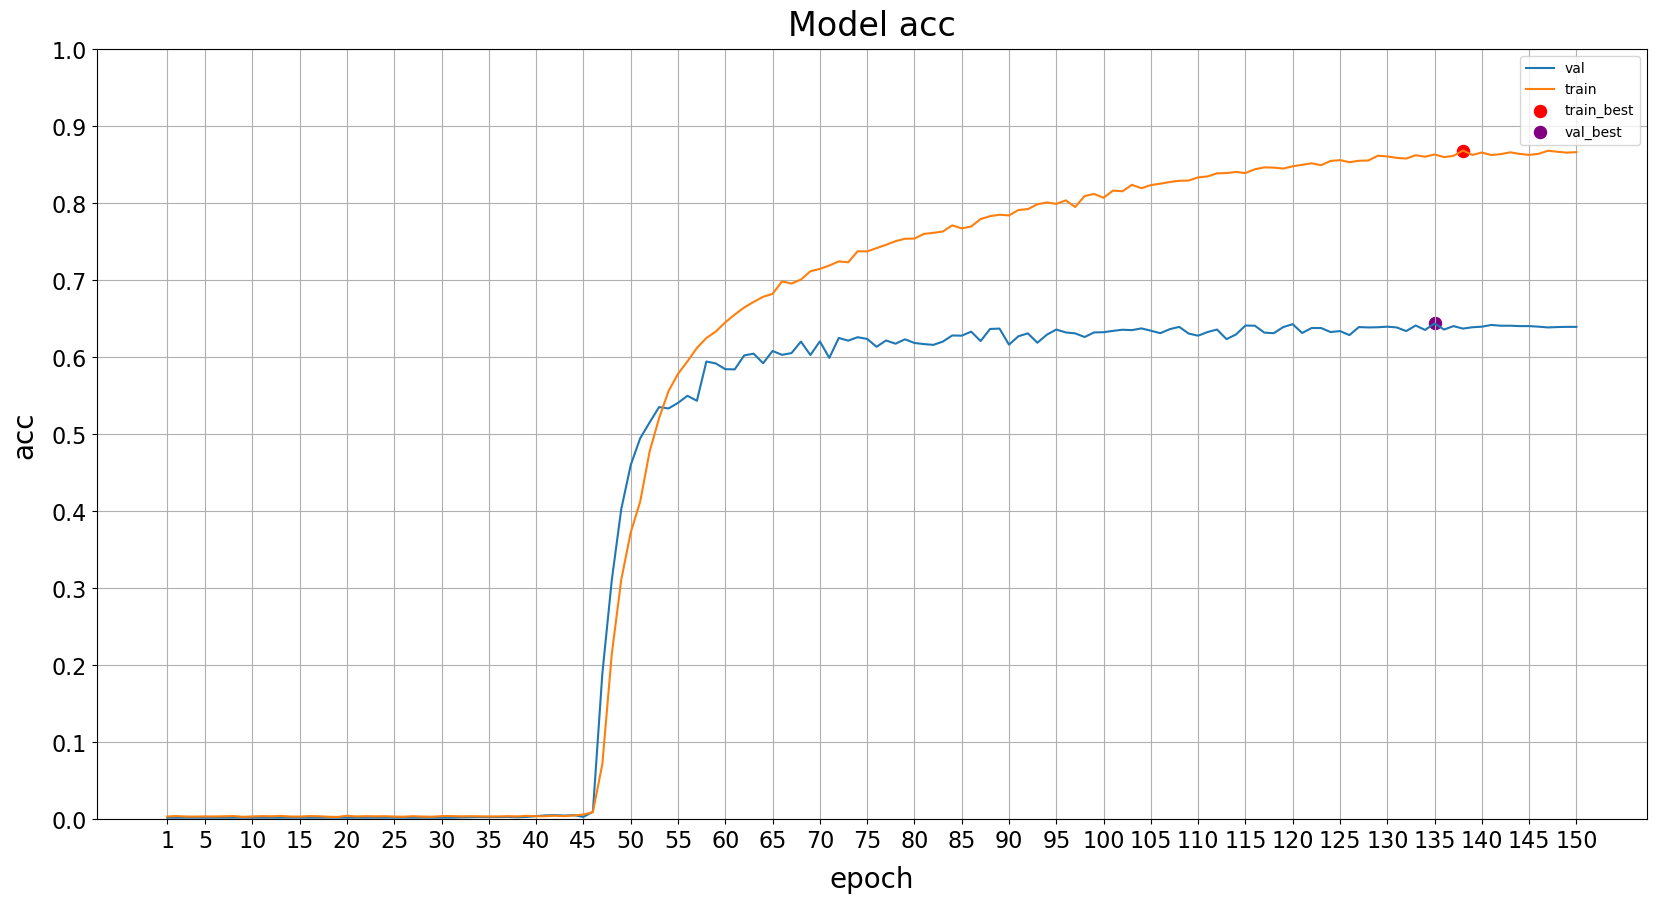

In [141]:
if TRAIN_MODEL:
    plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

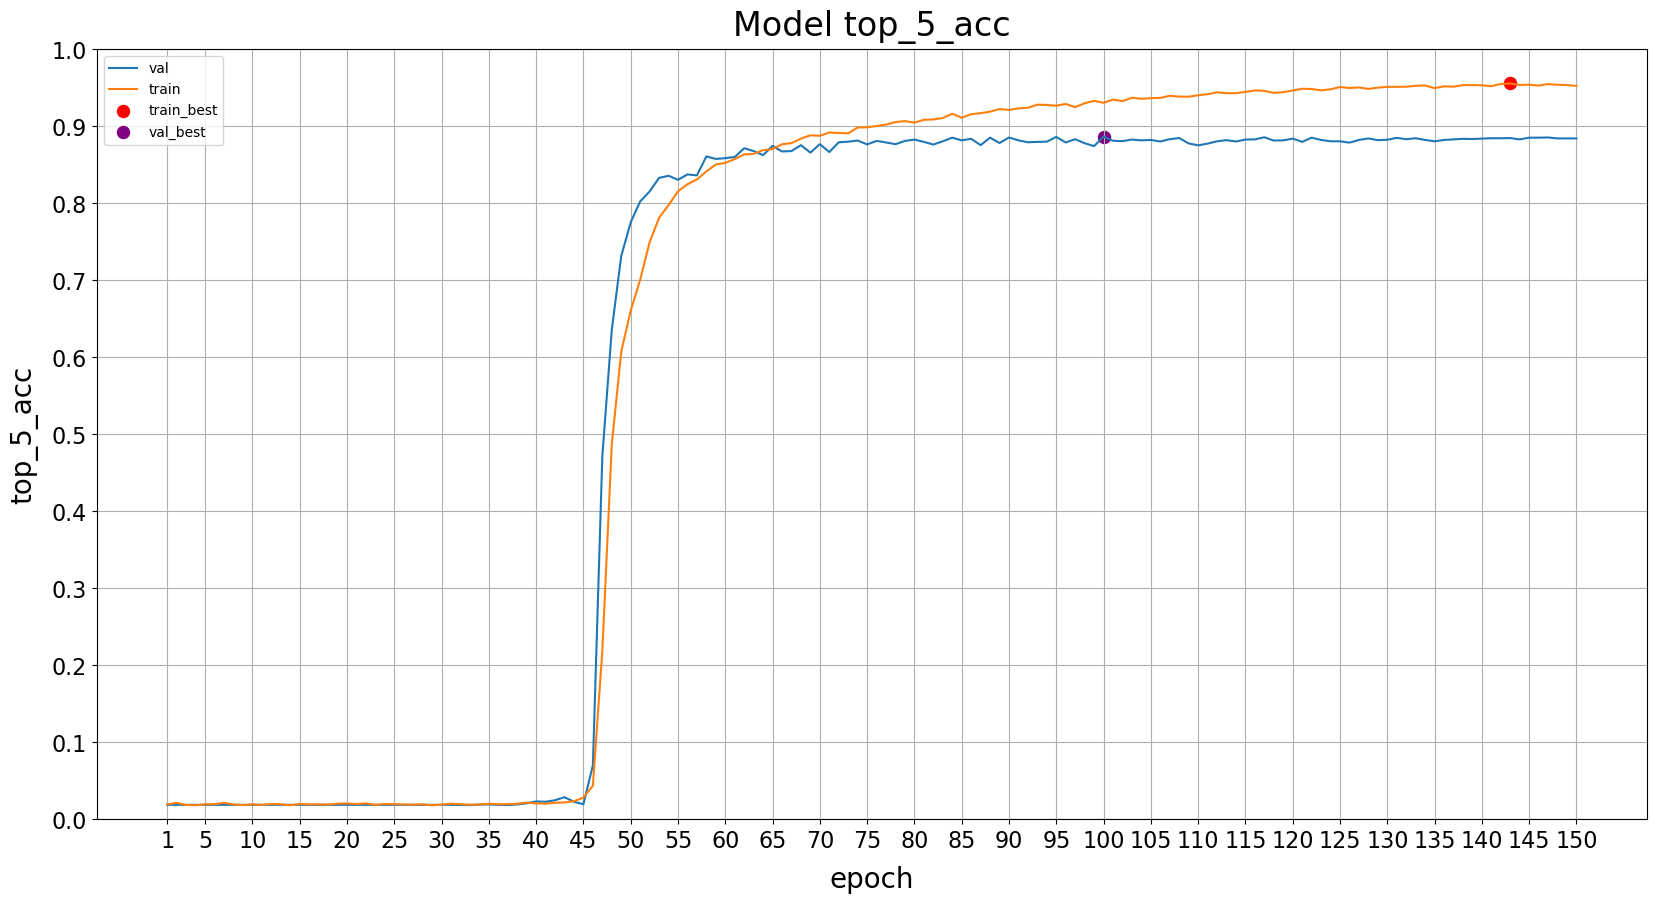

In [142]:
if TRAIN_MODEL:
    plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

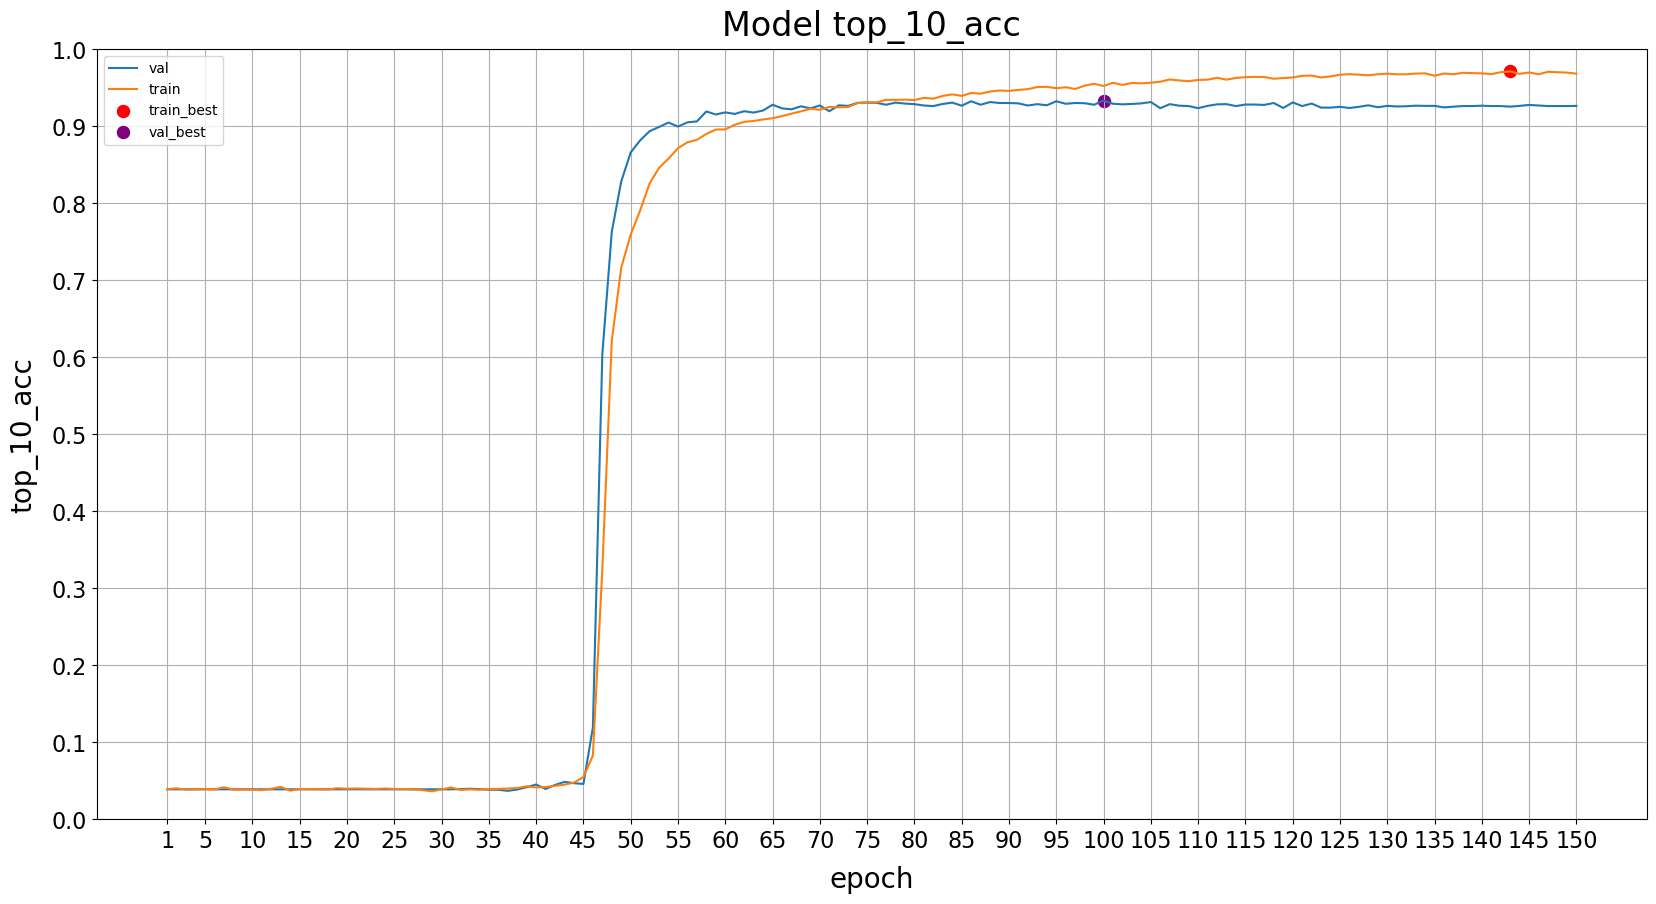

In [143]:
if TRAIN_MODEL:
    plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

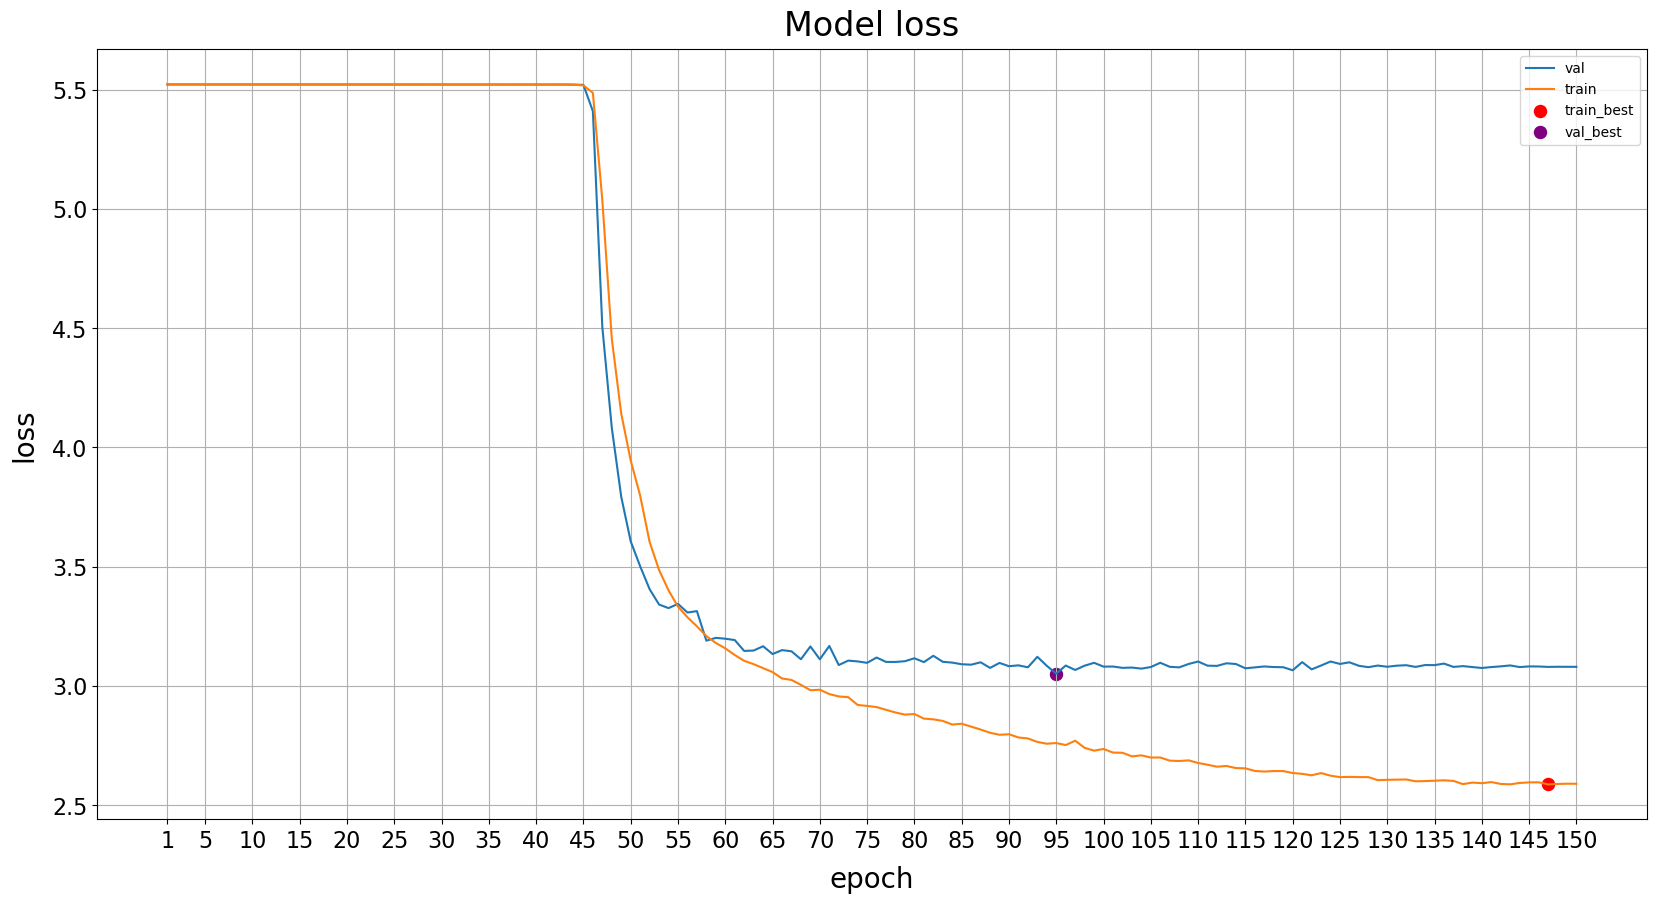

In [144]:
if TRAIN_MODEL:
    plot_history_metric('loss', f_best=np.argmin)

In [145]:
y_pred_probs = model.predict({'frames' : X_test,'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TEST }, verbose=2).argmax(axis=1)
accuracy = accuracy_score(y_test, y_pred_probs)
print(f"Test Accuracy: {accuracy:.4f}")

170/170 - 4s - 4s/epoch - 25ms/step
Test Accuracy: 0.4410


In [147]:
# Validation Predictions
y_val_pred_2 = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
# Label
labels_2 = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]

126/126 - 3s - 3s/epoch - 23ms/step


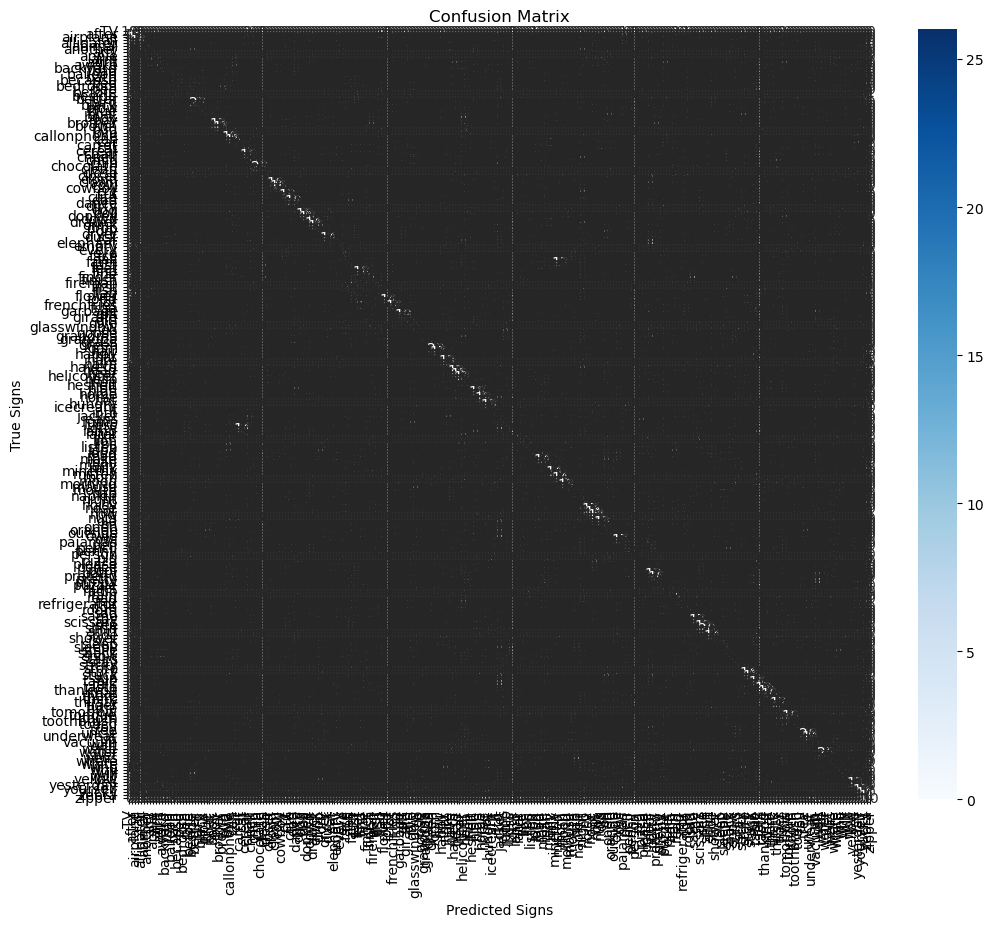

In [199]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = y_pred_probs
unique_ordinals = list(ORD2SIGN.keys())
unique_signs = list(ORD2SIGN.values())
cm = confusion_matrix(y_true, y_pred,labels=unique_ordinals)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=unique_signs, yticklabels=unique_signs)
plt.xlabel('Predicted Signs')
plt.ylabel('True Signs')
plt.title('Confusion Matrix')
plt.show()


In [182]:
def print_classification_report():
    # Classification report for all signs
    classification_report = sklearn.metrics.classification_report(
            y_test,
            y_pred_probs,
            target_names=labels_2,
            output_dict=True,
        )
    # Round Data for better readability
    classification_report = pd.DataFrame(classification_report).T
    classification_report = classification_report.round(2)
    classification_report = classification_report.astype({
            'support': np.uint16,
        })
    # Add signs
    classification_report['sign'] = [e if e in SIGN2ORD else -1 for e in classification_report.index]
    classification_report['sign_ord'] = classification_report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
    # Sort on F1-score
    classification_report = pd.concat((
        classification_report.head(NUM_CLASSES).sort_values('f1-score', ascending=False),
#         classification_report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(classification_report)
    
    return classification_report

df_classification_report = print_classification_report()


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support,sign,sign_ord
water,0.93,0.96,0.94,26,water,234
shhh,0.91,0.91,0.91,22,shhh,194
gum,0.88,0.85,0.87,27,gum,103
callonphone,0.83,0.90,0.86,21,callonphone,34
chocolate,0.79,0.92,0.85,24,chocolate,44
hair,0.94,0.77,0.85,22,hair,104
uncle,0.81,0.84,0.83,31,uncle,228
owl,0.94,0.74,0.83,23,owl,165
nose,0.94,0.68,0.79,25,nose,155
drink,0.89,0.70,0.78,23,drink,63


In [35]:
model_2 = lstm_model
# Actual Training
lstm_history_2 = model_2.fit(
        x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
        steps_per_epoch=len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
        epochs=50,
        # Only used for validation data since training data is a generator
        batch_size=BATCH_SIZE,
        validation_data=validation_data,
        callbacks=[
#             lr_callback,
#             WeightDecayCallback(),
            increase_stopping,
        ],
        verbose = VERBOSE,
    )

Epoch 1/50
40/40 [==============================] - 52s 943ms/step - loss: 5.2404 - acc: 0.0374 - top_5_acc: 0.1324 - top_10_acc: 0.2082 - val_loss: 4.6995 - val_acc: 0.1199 - val_top_5_acc: 0.3691 - val_top_10_acc: 0.5111
Epoch 2/50
40/40 [==============================] - 37s 918ms/step - loss: 4.5541 - acc: 0.1815 - top_5_acc: 0.4469 - top_10_acc: 0.5806 - val_loss: 4.1560 - val_acc: 0.2843 - val_top_5_acc: 0.6073 - val_top_10_acc: 0.7269
Epoch 3/50
40/40 [==============================] - 39s 965ms/step - loss: 4.1374 - acc: 0.3050 - top_5_acc: 0.6010 - top_10_acc: 0.7125 - val_loss: 3.8281 - val_acc: 0.3738 - val_top_5_acc: 0.6956 - val_top_10_acc: 0.8105
Epoch 4/50
40/40 [==============================] - 38s 963ms/step - loss: 3.8842 - acc: 0.3877 - top_5_acc: 0.6734 - top_10_acc: 0.7676 - val_loss: 3.6304 - val_acc: 0.4409 - val_top_5_acc: 0.7508 - val_top_10_acc: 0.8466
Epoch 5/50
40/40 [==============================] - 38s 962ms/step - loss: 3.7122 - acc: 0.4402 - top_5_acc:

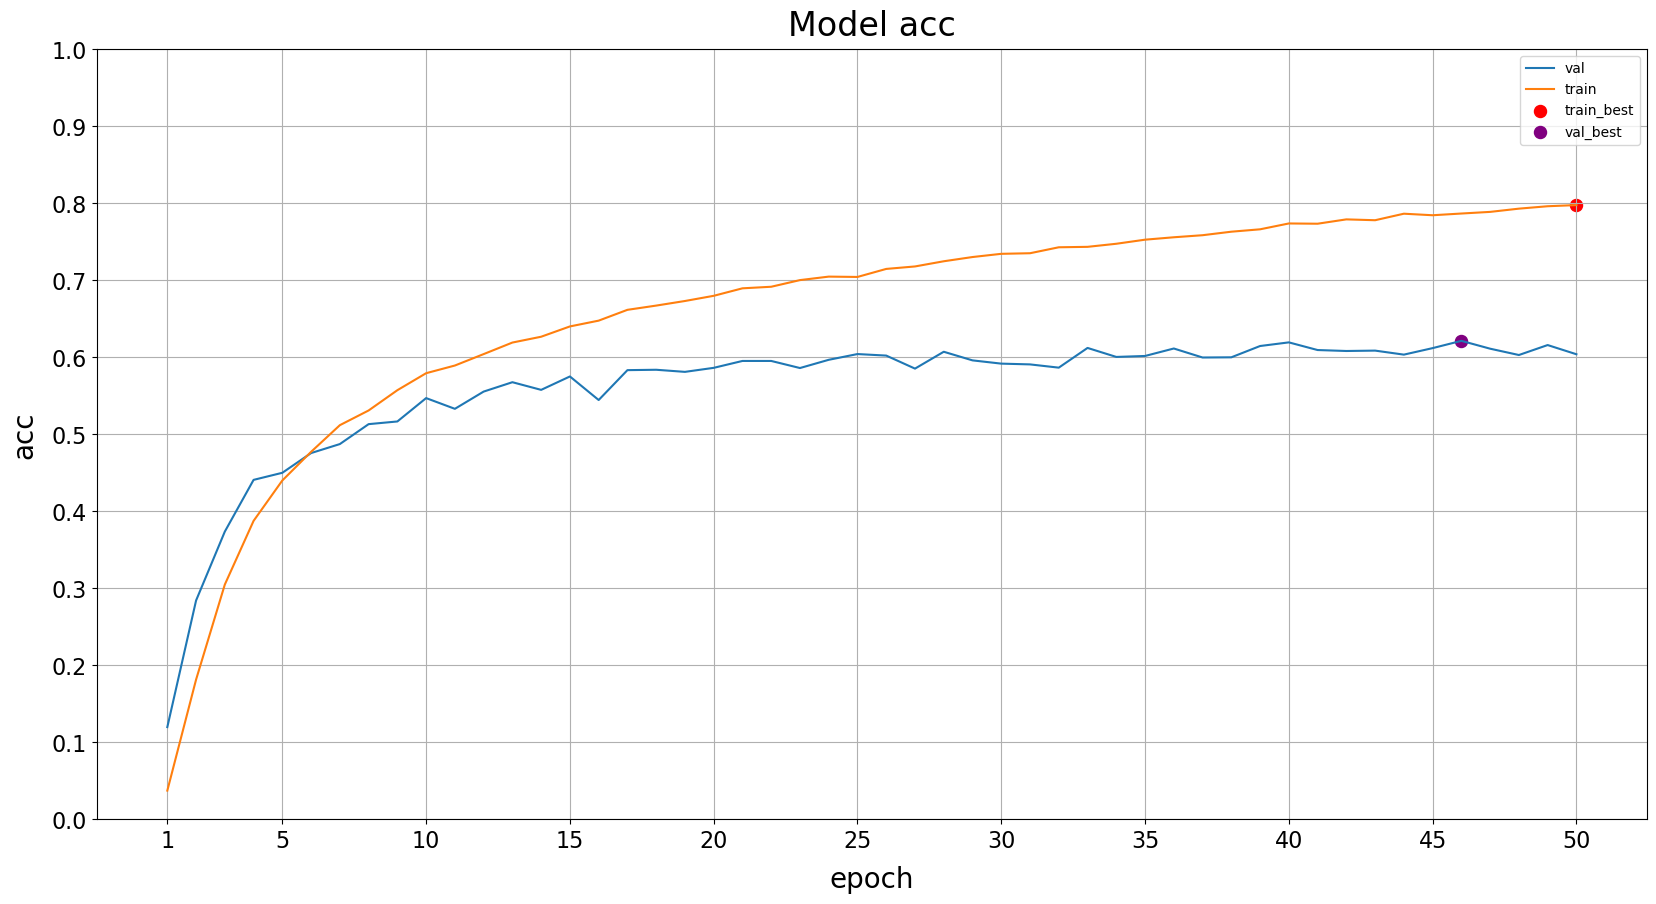

In [38]:
if TRAIN_MODEL:
    plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

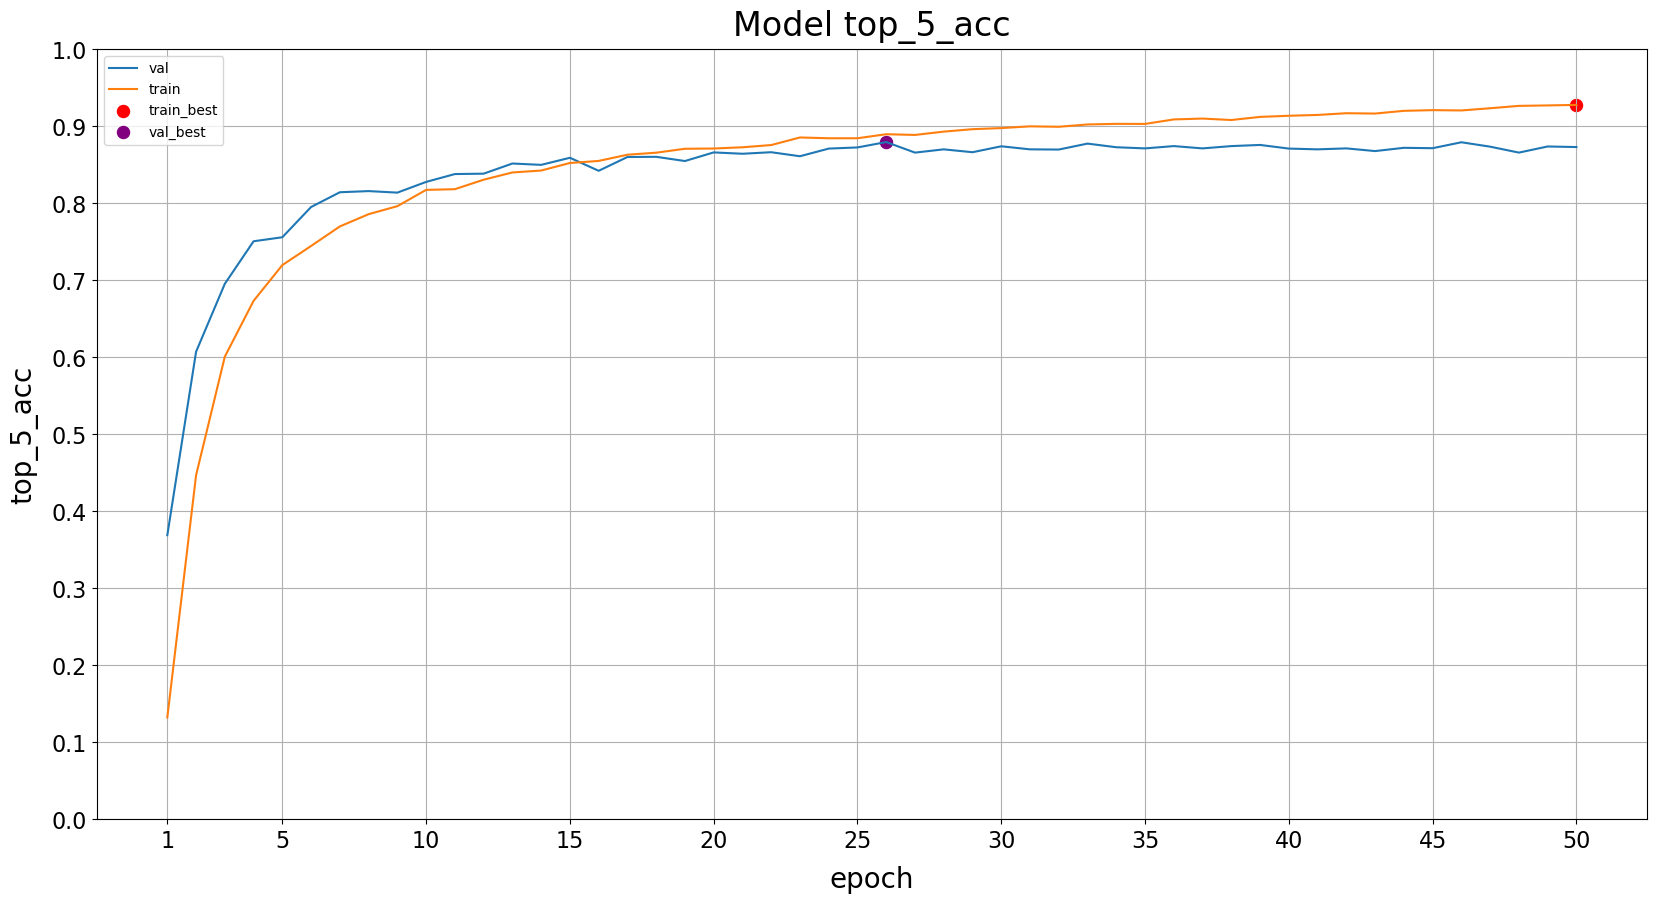

In [39]:
if TRAIN_MODEL:
    plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

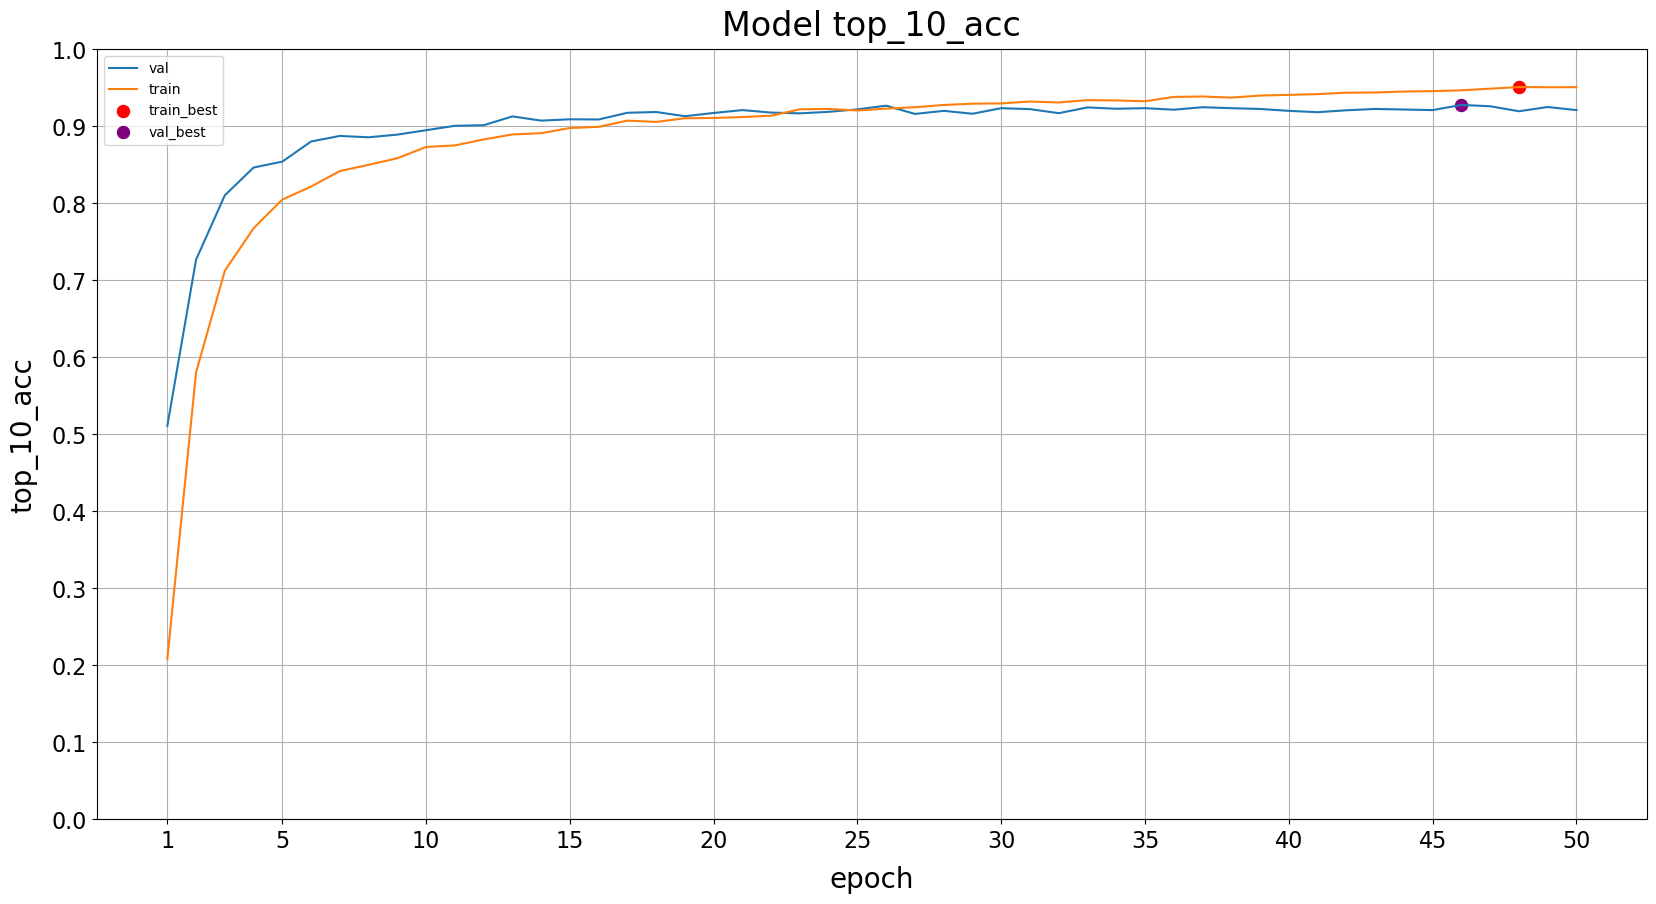

In [40]:
if TRAIN_MODEL:
    plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

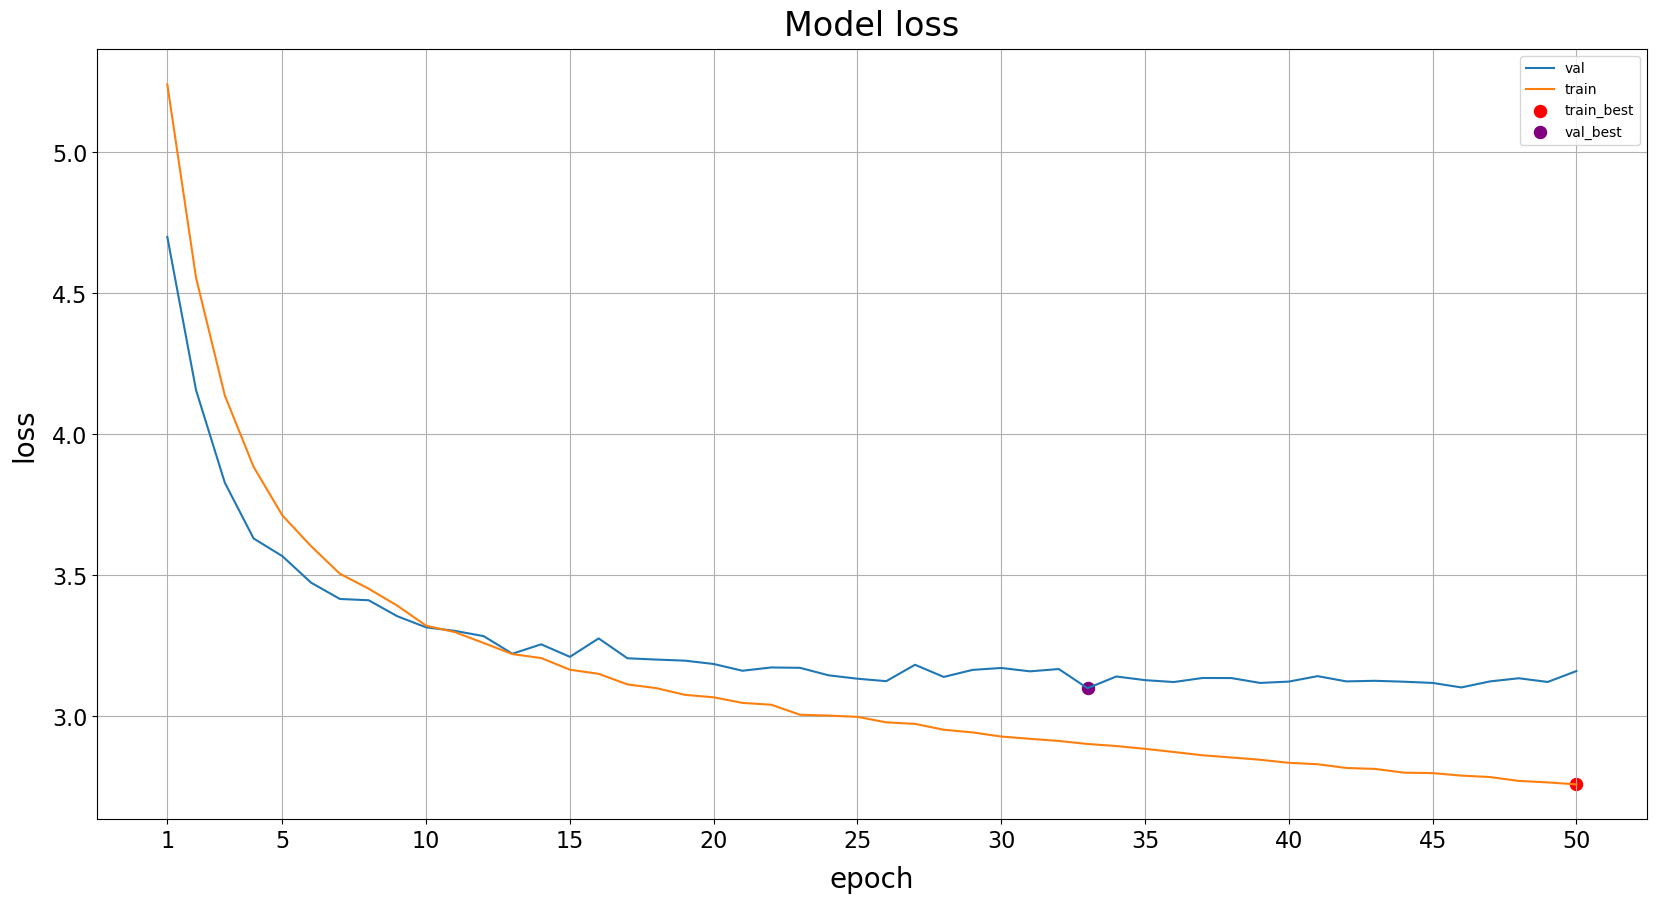

In [41]:
if TRAIN_MODEL:
    plot_history_metric('loss', f_best=np.argmin)